## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "Anchors" notebook
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 25.6,
 5: 27.1,
 10: 27.9,
 20: 29.6,
 30: 31.3,
 40: 32.7,
 50: 34.1,
 60: 35.6,
 70: 37.2,
 80: 39.1,
 90: 41.8,
 95: 44.6,
 99: 60.103000000000065}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.5,
 5: 7.7,
 10: 7.8,
 20: 8.0,
 30: 8.1,
 40: 8.2,
 50: 8.3,
 60: 8.5,
 70: 8.6,
 80: 8.8,
 90: 9.0,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.39, sd=0.42)
   - 0.1 weight on <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.04, sd=0.63)
   - 0.1 weight on <Distribution> lognorm(mean=1.7, sd=0.37)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.85 weight on <Distribution> lognorm(mean=1.7, sd=0.37)
   - 0.15 weight on <Distribution> lognorm(mean=2.33, sd=0.23)},
 'integration': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=2.25, sd=0.7)},
 'real_world_feedback': {'prob': 

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(1.5, 3.5),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 23),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             '2025_spend_doubling_time': sq.norm(0.93, 1.05, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1079670.51it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031313514534485787,
 50: 0.000398314940884579,
 60: 0.0005111176305540851,
 70: 0.0007120434306236142,
 80: 0.0010483247617548669,
 90: 0.0022909926138260503,
 95: 0.004256726724206942,
 99: 0.009200204099943965}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.2e+09',
 50: '9.2e+09',
 60: '1.2e+10',
 70: '1.6e+10',
 80: '2.4e+10',
 90: '5.3e+10',
 95: '9.8e+10',
 99: '2.1e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 33.6 log FLOP (~4 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 3.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.8 max log FLOP (697 septillion) available - TAI takes 33.6 log FLOP (4 decillion) - log $ 15.3 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 33.5 log FLOP (3 decillion) - log $ 15.0 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.6 (434 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.

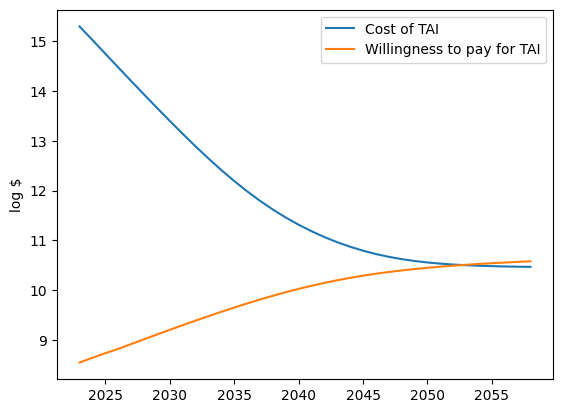

-
-
## SAMPLE RUN 2 ##
It takes 39.5 log FLOP (~3 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.0 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 4.8 years to a max of 0.061132% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 39.5 log FLOP (3 million decillion) - log $ 21.2 to buy TAI (2 sextillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.5)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 39.2 log FLOP (2 million decillion) - log $ 20.8 to buy TAI (586 quintillion) vs. willingness to pay log $ 9.2 (2 billion) - 18.4 log FLOP per $ (3 quintillion) (Effecti

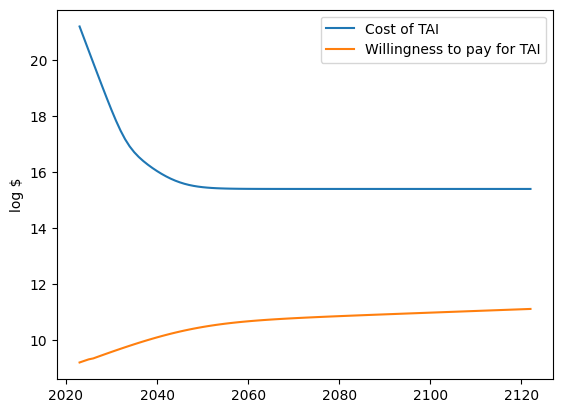

-
-
## SAMPLE RUN 3 ##
It takes 30.5 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 3.8 years to a max of 0.347481% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.3 max log FLOP (199 septillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.2 to buy TAI (2 trillion) vs. willingness to pay log $ 8.0 (100 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.3)
Year: 2024 - 26.5 max log FLOP (311 septillion) available - TAI takes 30.4 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (938 billion) vs. willingness to pay log $ 8.1 (120 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

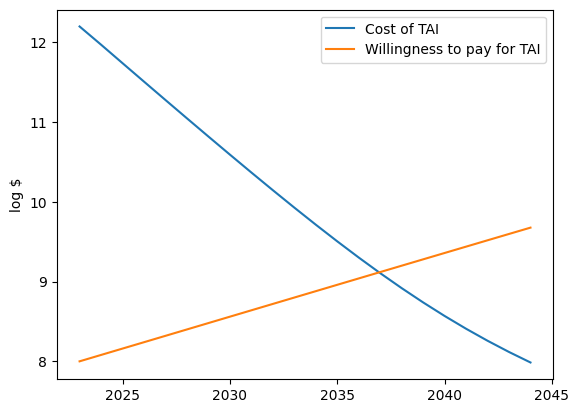

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.29it/s]


Shuffling data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 193.06it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2034',
 '10%: 2036',
 '15%: 2038',
 '20%: 2040',
 '25%: 2042',
 '35%: 2046',
 '50%: 2057',
 '60%: 2076',
 '75%: >2123',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 11 years from now',
 '10%: 13 years from now',
 '15%: 15 years from now',
 '20%: 17 years from now',
 '25%: 19 years from now',
 '35%: 23 years from now',
 '50%: 34 years from now',
 '60%: 53 years from now',
 '75%: >100 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.2%
2028-2029: 0.7%
2030-2034: 5.6%
2035-2039: 12.4%
2040-2049: 22.3%
2050-2059: 11.7%
2060-2069: 5.4%
2070-2079: 2.4%
2080-2089: 1.6%
2090-2099: 1.0%
2100-2109: 1.0%
2110-2119: 0.9%
>2120: 34.8%
-

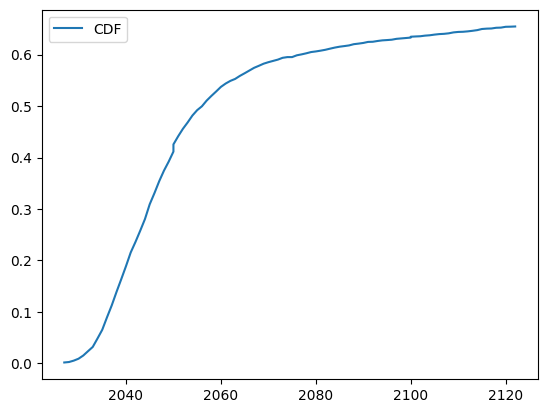

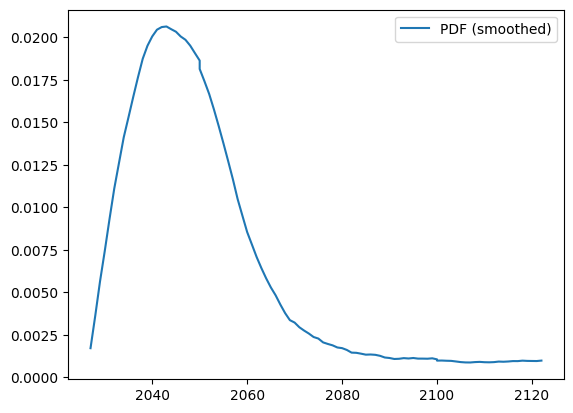

-
-
## TAI FLOP SIZE ##
{1: 25.5,
 5: 27.1,
 10: 28.0,
 20: 29.9,
 30: 31.6,
 40: 33.0,
 50: 34.4,
 60: 35.6,
 70: 37.2,
 80: 39.3,
 90: 42.4,
 95: 44.8,
 99: 64.7}


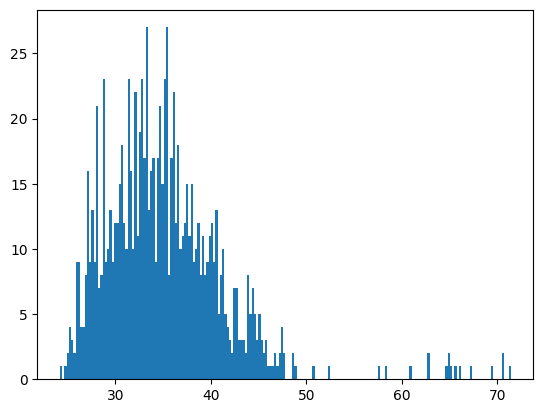

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 21.2,
 5: 15.1,
 10: 12.7,
 20: 10.3,
 30: 8.8,
 40: 7.6,
 50: 6.7,
 60: 5.8,
 70: 5.2,
 80: 4.4,
 90: 3.5,
 95: 3.0,
 99: 2.3}


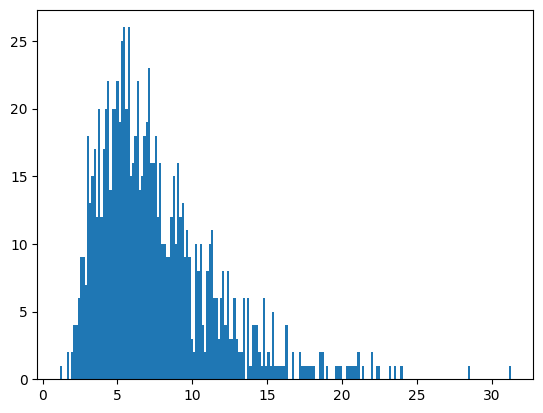

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.8,
 5: 3.5,
 10: 3.3,
 20: 3.0,
 30: 2.8,
 40: 2.7,
 50: 2.5,
 60: 2.4,
 70: 2.2,
 80: 2.0,
 90: 1.7,
 95: 1.5,
 99: 1.1}


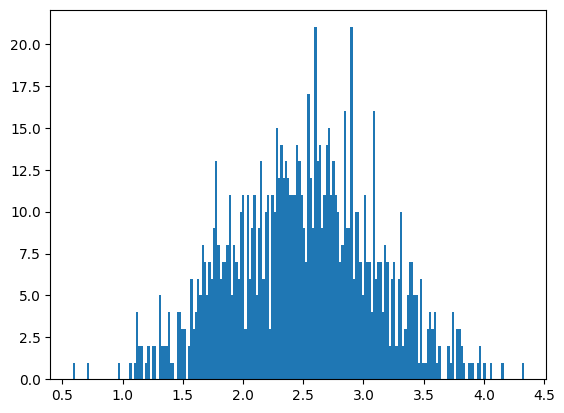

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.7,
 5: 21.0,
 10: 21.3,
 20: 21.5,
 30: 21.7,
 40: 21.8,
 50: 22.0,
 60: 22.2,
 70: 22.3,
 80: 22.5,
 90: 22.8,
 95: 23.1,
 99: 23.4}


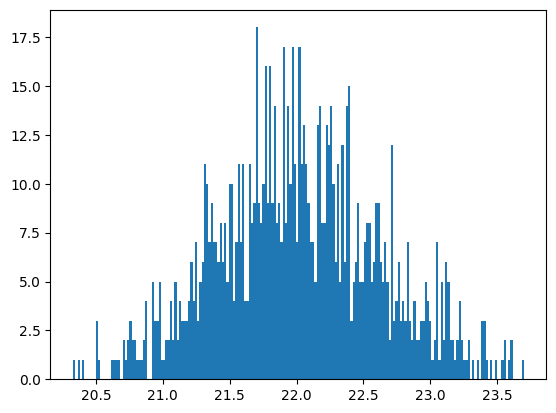

-
-
## INITIAL PAY ##
{1: 7.4,
 5: 7.7,
 10: 7.8,
 20: 8.0,
 30: 8.1,
 40: 8.2,
 50: 8.4,
 60: 8.5,
 70: 8.6,
 80: 8.8,
 90: 9.1,
 95: 9.3,
 99: 9.9}


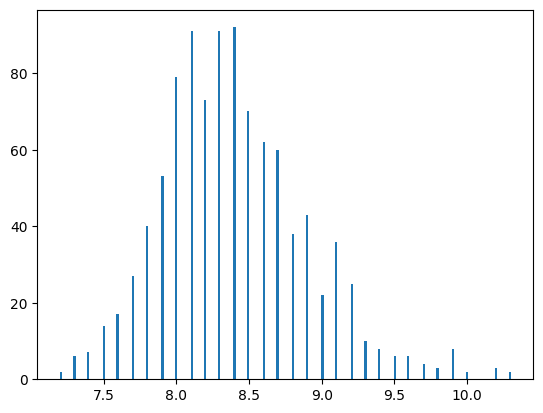

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}


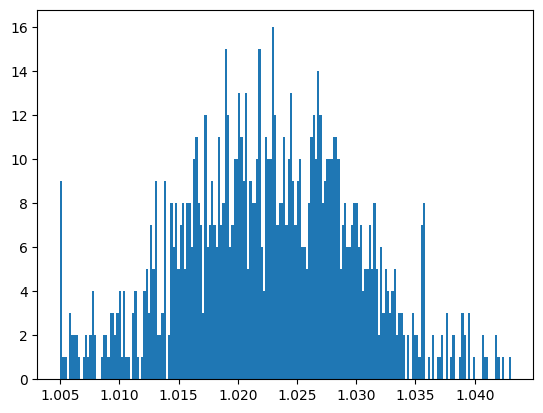

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.0003,
 50: 0.00037,
 60: 0.00047,
 70: 0.00061,
 80: 0.0009,
 90: 0.00185,
 95: 0.00329,
 99: 0.0101}


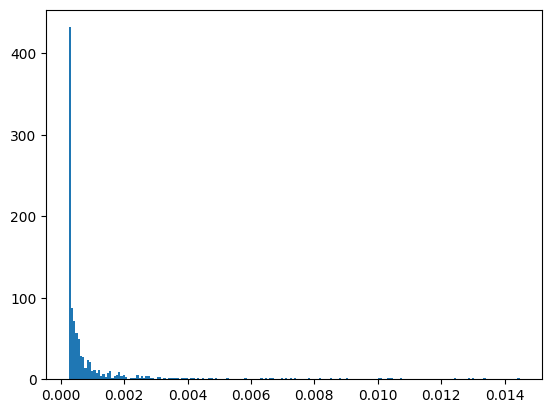

-
-
## SPEND DOUBLING TIME ##
{1: 5.0,
 5: 4.4,
 10: 4.2,
 20: 3.7,
 30: 3.4,
 40: 3.2,
 50: 3.0,
 60: 2.8,
 70: 2.5,
 80: 2.2,
 90: 1.9,
 95: 1.6,
 99: 1.0}


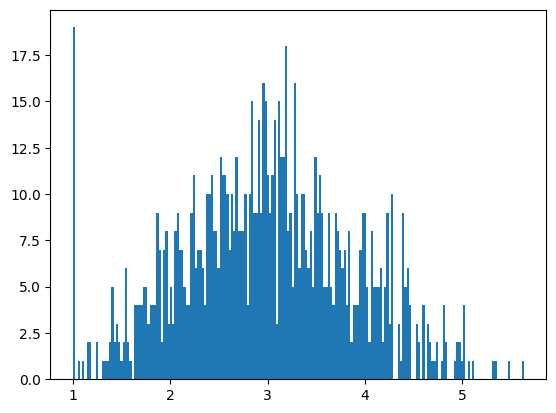

-
-
-
-
## GDP Over Time ##


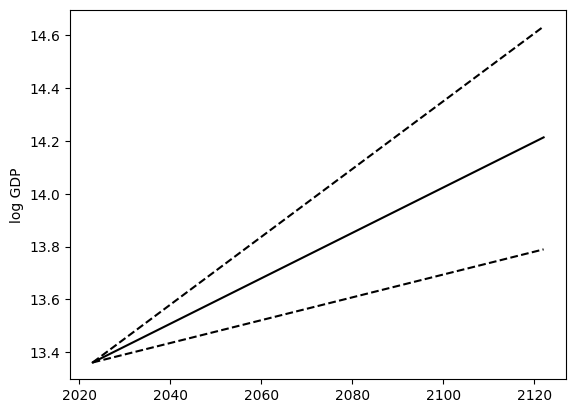

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

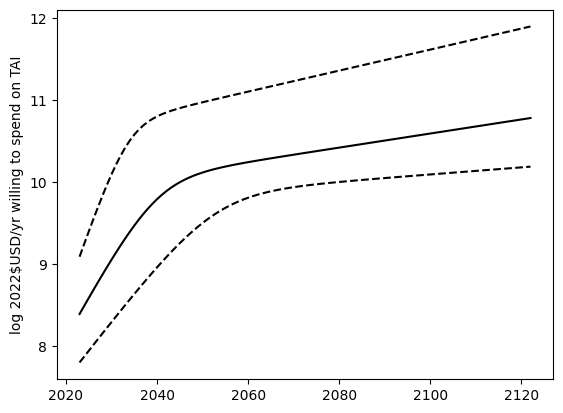

Year: 2023 - willingness log 2022$USD per year 8.4 (~244 million) 90% CI 7.8 (~62 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.5 (~305 million) 90% CI 7.9 (~73 million) - 9.2 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.6 (~382 million) 90% CI 7.9 (~86 million) - 9.4 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.7 (~476 million) 90% CI 8.0 (~102 million) - 9.5 (~3 billion)
Year: 2027 - willingness log 2022$USD per year 8.8 (~592 million) 90% CI 8.1 (~120 million) - 9.7 (~5 billion)
Year: 2028 - willingness log 2022$USD per year 8.9 (~735 million) 90% CI 8.1 (~141 million) - 9.8 (~7 billion)
Year: 2029 - willingness log 2022$USD per year 9.0 (~909 million) 90% CI 8.2 (~165 million) - 10.0 (~9 billion)
Year: 2030 - willingness log 2022$USD per year 9.0 (~1 billion) 90% CI 8.3 (~194 million) - 10.1 (~12 billion)
Year: 2031 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.4 (~228 million) - 10.2 (~16 billion)
Yea

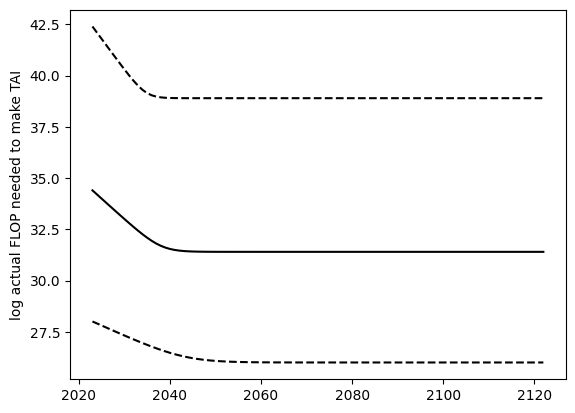

Year: 2023 - log FLOP needed for TAI 34.4 (~25 decillion) 90% CI 28.0 (~10 octillion) - 42.4 (~3 billion decillion)
Year: 2024 - log FLOP needed for TAI 34.2 (~16 decillion) 90% CI 27.9 (~8 octillion) - 42.1 (~1 billion decillion)
Year: 2025 - log FLOP needed for TAI 34.0 (~10 decillion) 90% CI 27.8 (~6 octillion) - 41.8 (~629 million decillion)
Year: 2026 - log FLOP needed for TAI 33.8 (~6 decillion) 90% CI 27.7 (~5 octillion) - 41.5 (~315 million decillion)
Year: 2027 - log FLOP needed for TAI 33.6 (~4 decillion) 90% CI 27.6 (~4 octillion) - 41.2 (~158 million decillion)
Year: 2028 - log FLOP needed for TAI 33.4 (~3 decillion) 90% CI 27.5 (~3 octillion) - 40.9 (~79 million decillion)
Year: 2029 - log FLOP needed for TAI 33.2 (~2 decillion) 90% CI 27.4 (~3 octillion) - 40.6 (~40 million decillion)
Year: 2030 - log FLOP needed for TAI 33.0 (~1 decillion) 90% CI 27.3 (~2 octillion) - 40.3 (~20 million decillion)
Year: 2031 - log FLOP needed for TAI 32.8 (~648 nonillion) 90% CI 27.2 (~2 

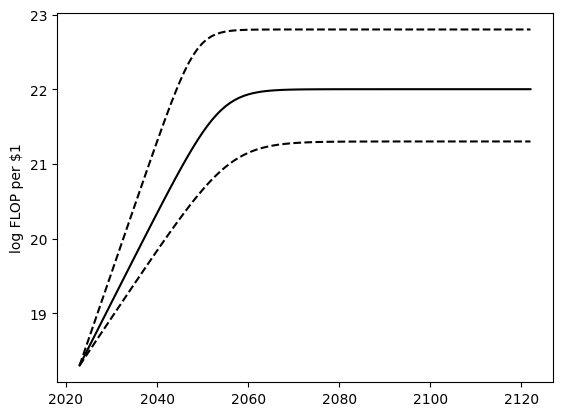

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~2 quintillion) - 18.5 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.7 (~5 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.8 (~7 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 19.0 (~10 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~6 quintillion) - 19.2 (~15 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.8 (~7 quintillion) - 19.4 (~23 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 18.9 (~9 quintillion) - 19.5 (~35 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.0 (~11 quintillion) - 19.7 (~52 quint

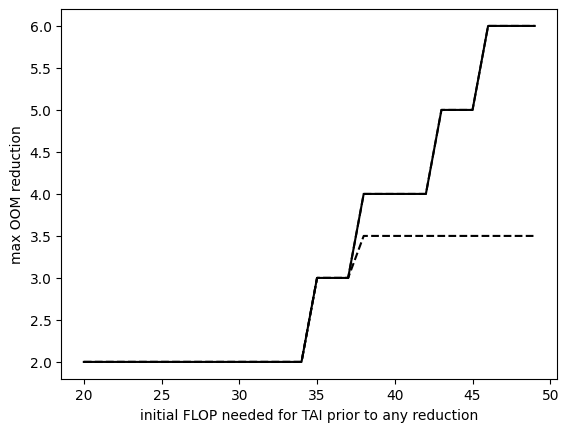

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

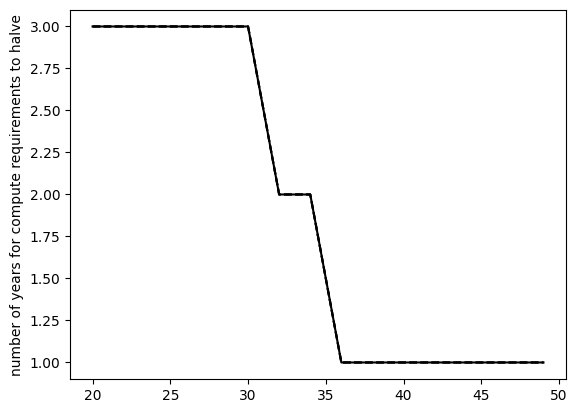

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

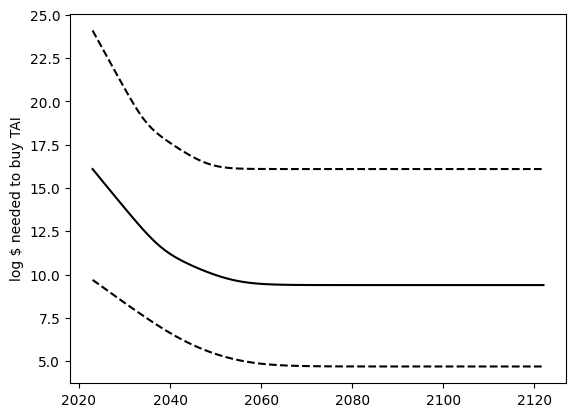

Year: 2023 - 16.1 log 2022$USD to buy TAI (~13 quadrillion) 90% CI 9.7 (~5 billion) - 24.1 (~1 septillion)
Year: 2024 - 15.8 log 2022$USD to buy TAI (~6 quadrillion) 90% CI 9.5 (~3 billion) - 23.6 (~419 sextillion)
Year: 2025 - 15.5 log 2022$USD to buy TAI (~3 quadrillion) 90% CI 9.3 (~2 billion) - 23.1 (~139 sextillion)
Year: 2026 - 15.1 log 2022$USD to buy TAI (~1 quadrillion) 90% CI 9.1 (~1 billion) - 22.7 (~46 sextillion)
Year: 2027 - 14.8 log 2022$USD to buy TAI (~659 trillion) 90% CI 8.9 (~882 million) - 22.2 (~15 sextillion)
Year: 2028 - 14.5 log 2022$USD to buy TAI (~316 trillion) 90% CI 8.8 (~571 million) - 21.7 (~5 sextillion)
Year: 2029 - 14.2 log 2022$USD to buy TAI (~152 trillion) 90% CI 8.6 (~371 million) - 21.2 (~2 sextillion)
Year: 2030 - 13.9 log 2022$USD to buy TAI (~73 trillion) 90% CI 8.4 (~241 million) - 20.8 (~590 quintillion)
Year: 2031 - 13.5 log 2022$USD to buy TAI (~35 trillion) 90% CI 8.2 (~157 million) - 20.3 (~204 quintillion)
Year: 2032 - 13.2 log 2022$USD

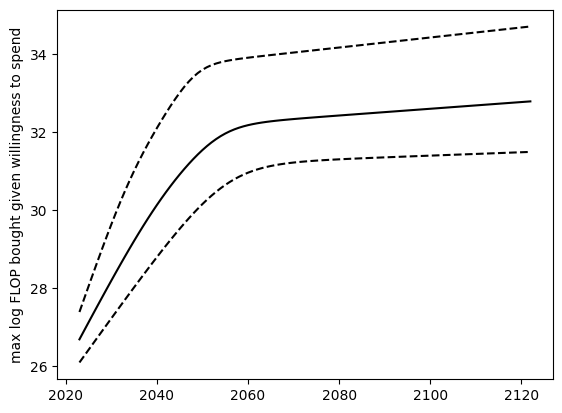

Year: 2023 - max log FLOP 26.7 (~487 septillion) 90% CI 26.1 (~124 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log FLOP 26.9 (~804 septillion) 90% CI 26.3 (~181 septillion) - 27.7 (~5 octillion)
Year: 2025 - max log FLOP 27.1 (~1 octillion) 90% CI 26.4 (~262 septillion) - 28.0 (~11 octillion)
Year: 2026 - max log FLOP 27.3 (~2 octillion) 90% CI 26.6 (~380 septillion) - 28.4 (~24 octillion)
Year: 2027 - max log FLOP 27.6 (~4 octillion) 90% CI 26.7 (~552 septillion) - 28.7 (~50 octillion)
Year: 2028 - max log FLOP 27.8 (~6 octillion) 90% CI 26.9 (~800 septillion) - 29.0 (~103 octillion)
Year: 2029 - max log FLOP 28.0 (~10 octillion) 90% CI 27.1 (~1 octillion) - 29.3 (~212 octillion)
Year: 2030 - max log FLOP 28.2 (~16 octillion) 90% CI 27.2 (~2 octillion) - 29.6 (~428 octillion)
Year: 2031 - max log FLOP 28.4 (~25 octillion) 90% CI 27.4 (~2 octillion) - 29.9 (~847 octillion)
Year: 2032 - max log FLOP 28.6 (~40 octillion) 90% CI 27.5 (~4 octillion) - 30.2 (~2 nonillion)
Year: 2033 

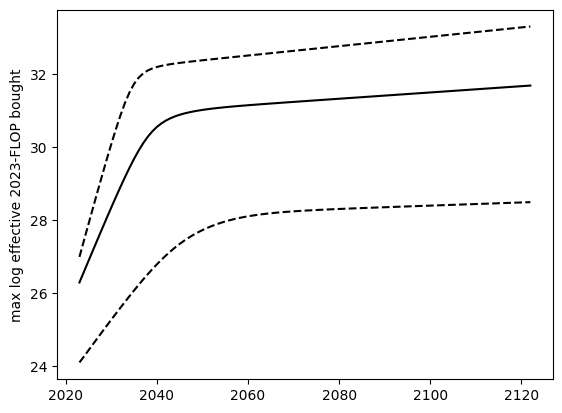

Year: 2023 - max log FLOP 26.3 (~194 septillion) 90% CI 24.1 (~1 septillion) - 27.0 (~971 septillion)
Year: 2024 - max log FLOP 26.6 (~384 septillion) 90% CI 24.3 (~2 septillion) - 27.4 (~3 octillion)
Year: 2025 - max log FLOP 26.9 (~762 septillion) 90% CI 24.4 (~3 septillion) - 27.9 (~8 octillion)
Year: 2026 - max log FLOP 27.2 (~2 octillion) 90% CI 24.6 (~4 septillion) - 28.3 (~22 octillion)
Year: 2027 - max log FLOP 27.5 (~3 octillion) 90% CI 24.8 (~6 septillion) - 28.8 (~62 octillion)
Year: 2028 - max log FLOP 27.8 (~6 octillion) 90% CI 24.9 (~9 septillion) - 29.2 (~170 octillion)
Year: 2029 - max log FLOP 28.1 (~11 octillion) 90% CI 25.1 (~13 septillion) - 29.7 (~458 octillion)
Year: 2030 - max log FLOP 28.3 (~22 octillion) 90% CI 25.3 (~19 septillion) - 30.1 (~1 nonillion)
Year: 2031 - max log FLOP 28.6 (~42 octillion) 90% CI 25.4 (~27 septillion) - 30.5 (~3 nonillion)
Year: 2032 - max log FLOP 28.9 (~80 octillion) 90% CI 25.6 (~39 septillion) - 30.9 (~7 nonillion)
Year: 2033 - m

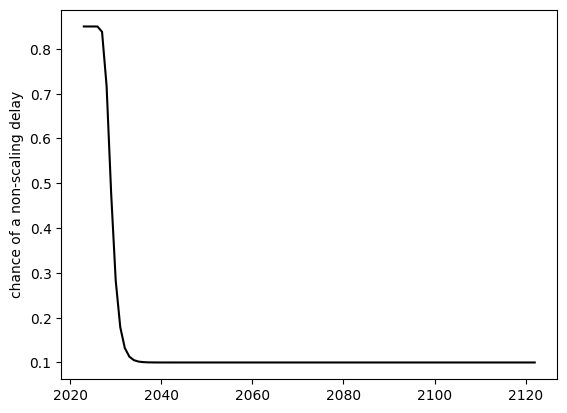

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 72%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2033

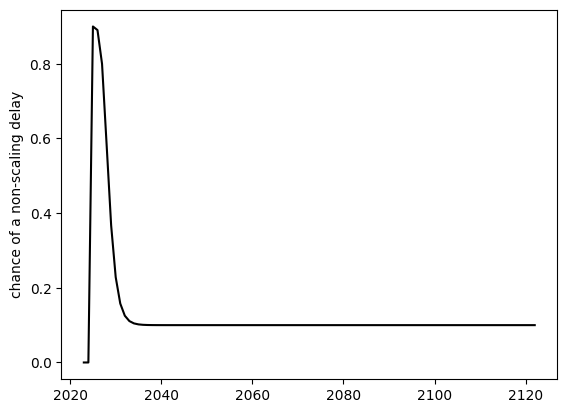

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2033 -

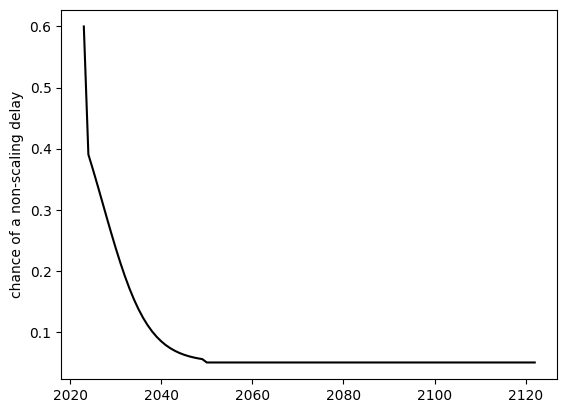

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 39%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 34%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2033

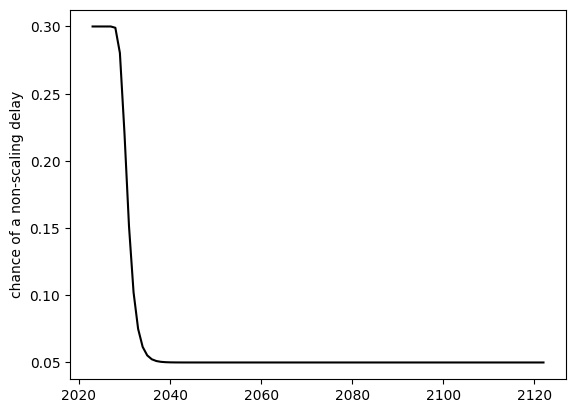

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

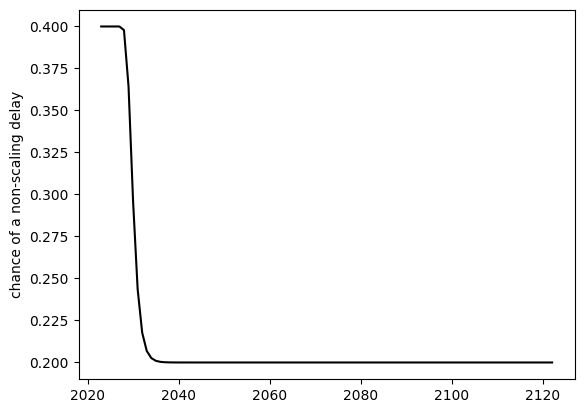

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 36%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2033

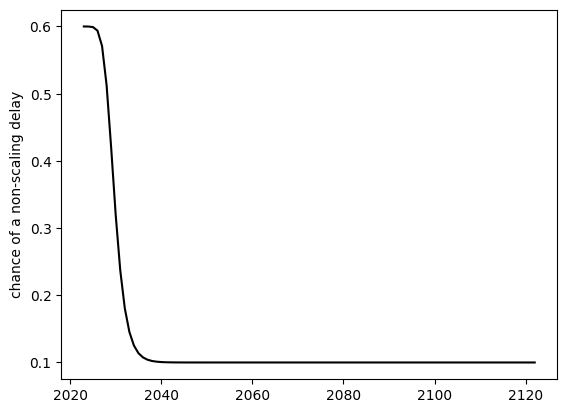

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 59%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 57%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 51%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2033

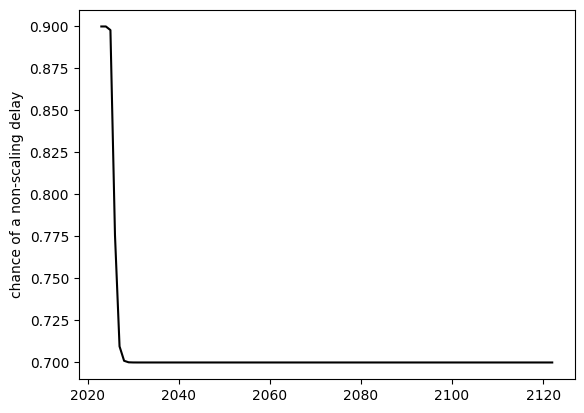

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 78%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 71%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2033

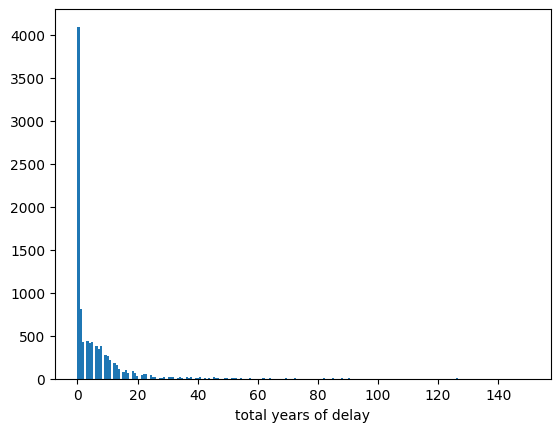

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 31.6 log FLOP (~40 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 4.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.007x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 31.6 log FLOP (40 nonillion) - log $ 13.3 to buy TAI (20 trillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.5 max log FLOP (348 septillion) available - TAI takes 31.5 log FLOP (31 nonillion) - log $ 13.1 to buy TAI (12 trillion) vs. willingness to pay log $ 8.1 (141 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP:

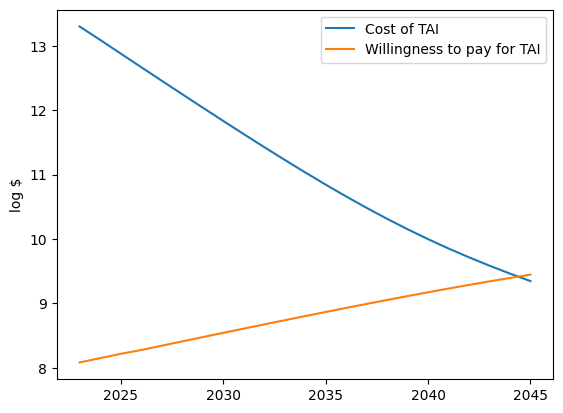

-
-
## SAMPLE RUN 5 ##
It takes 25.7 log FLOP (~50 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 9.4 log 2022$USD (~3 billion). This doubles every 3.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 25.7 log FLOP (50 septillion) - log $ 7.4 to buy TAI (25 million) vs. willingness to pay log $ 9.3 (2 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.6)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 34 years (total delay 34 years)
-- data p_nonscaling_issue p=0.0 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.6 -> Nonscaling delay occured
-- -

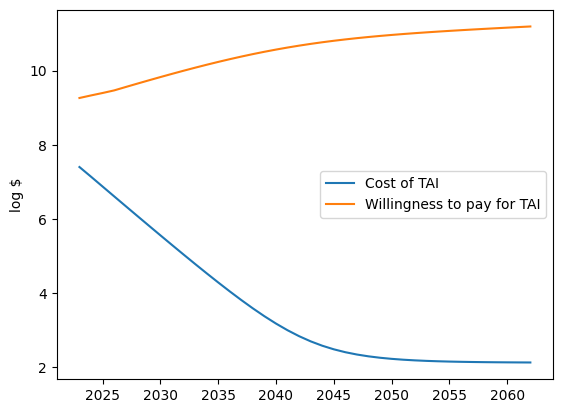

-
-
## SAMPLE RUN 6 ##
It takes 35.0 log FLOP (~100 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.5 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~469 million). This doubles every 4.1 years to a max of 0.032207% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.9 max log FLOP (880 septillion) available - TAI takes 35.0 log FLOP (100 decillion) - log $ 16.7 to buy TAI (50 quadrillion) vs. willingness to pay log $ 8.6 (441 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 34.8 log FLOP (63 decillion) - log $ 16.4 to buy TAI (26 quadrillion) vs. willingness to pay log $ 8.7 (518 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-l

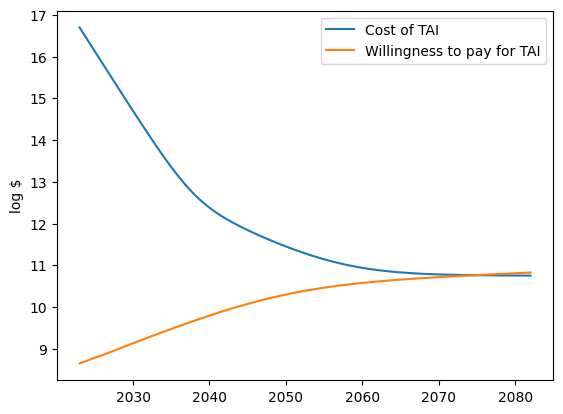

-
-
## SAMPLE RUN 7 ##
It takes 31.7 log FLOP (~50 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~62 million). This doubles every 2.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.1 max log FLOP (123 septillion) available - TAI takes 31.7 log FLOP (50 nonillion) - log $ 13.4 to buy TAI (25 trillion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.1)
Year: 2024 - 26.3 max log FLOP (207 septillion) available - TAI takes 31.6 log FLOP (38 nonillion) - log $ 13.2 to buy TAI (15 trillion) vs. willingness to pay log $ 7.9 (82 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.

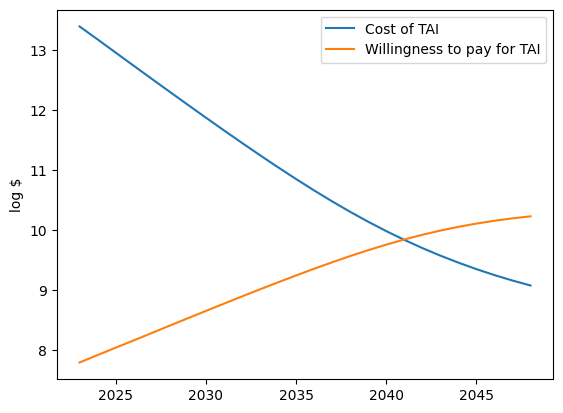

-
-
## SAMPLE RUN 8 ##
It takes 38.2 log FLOP (~158 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 20.4 log FLOP (~269 quintillion) per 2022$USD.
We are initially willing to pay 9.3 log 2022$USD (~2 billion). This doubles every 3.9 years to a max of 0.724323% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 19.9 to buy TAI (80 quintillion) vs. willingness to pay log $ 9.3 (2 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.6)
Year: 2024 - 27.8 max log FLOP (6 octillion) available - TAI takes 37.9 log FLOP (79 thousand decillion) - log $ 19.5 to buy TAI (31 quintillion) vs. willingness to pay log $ 9.4 (2 billion) - 18.4 log FLOP per $ (3 quintillion)

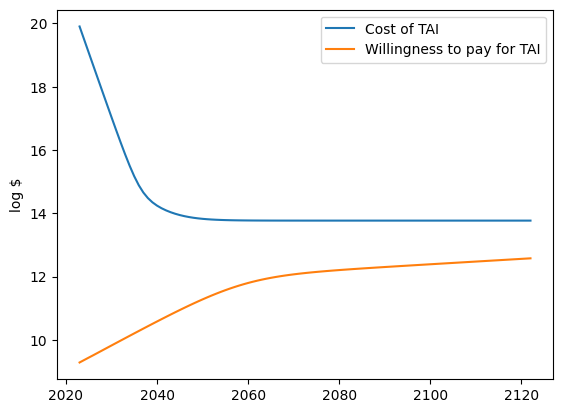

-
-
## SAMPLE RUN 9 ##
It takes 36.1 log FLOP (~1 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 4.2 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~196 million). This doubles every 4.2 years to a max of 0.052662% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.6 max log FLOP (385 septillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.8 to buy TAI (632 quadrillion) vs. willingness to pay log $ 8.3 (193 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.7 max log FLOP (534 septillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.4 to buy TAI (269 quadrillion) vs. willingness to pay log $ 8.4 (228 million) - 18.4 log FLOP per $ (2 quintillio

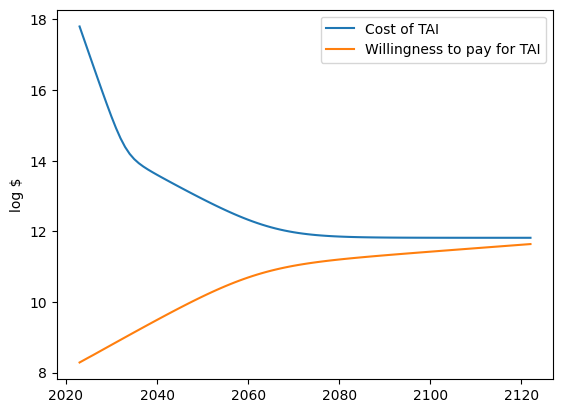

-
-
## SAMPLE RUN 10 ##
It takes 37.0 log FLOP (~10 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 2.2 years to a max of 0.03335% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.2 max log FLOP (155 septillion) available - TAI takes 37.0 log FLOP (10 thousand decillion) - log $ 18.7 to buy TAI (5 quintillion) vs. willingness to pay log $ 7.9 (78 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.5 max log FLOP (291 septillion) available - TAI takes 36.7 log FLOP (5 thousand decillion) - log $ 18.3 to buy TAI (2 quintillion) vs. willingness to pay log $ 8.0 (106 million) - 18.4 log FLOP per $ (3 quinti

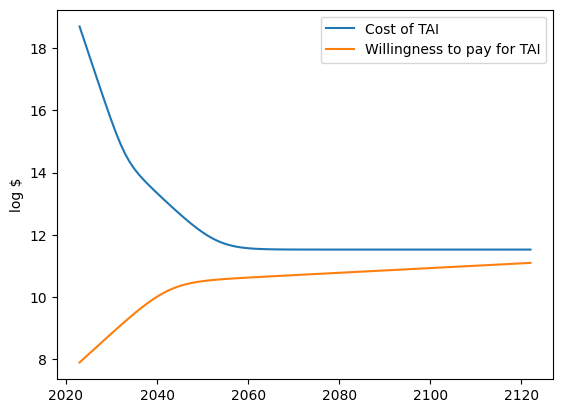

-
-
## SAMPLE RUN 11 ##
It takes 36.8 log FLOP (~6 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.4 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~372 million). This doubles every 2.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.8 max log FLOP (698 septillion) available - TAI takes 36.8 log FLOP (6 thousand decillion) - log $ 18.5 to buy TAI (3 quintillion) vs. willingness to pay log $ 8.5 (350 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 36.5 log FLOP (3 thousand decillion) - log $ 18.0 to buy TAI (958 quadrillion) vs. willingness to pay log $ 8.6 (439 million) - 18.5 log FLOP per $ (3 quintilli

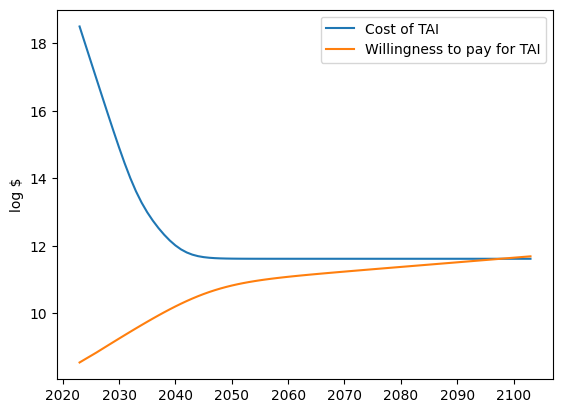

-
-
## SAMPLE RUN 12 ##
It takes 34.2 log FLOP (~16 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 3.9 years to a max of 0.142451% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.2 max log FLOP (158 septillion) available - TAI takes 34.2 log FLOP (16 decillion) - log $ 15.9 to buy TAI (8 quadrillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.4 max log FLOP (235 septillion) available - TAI takes 34.0 log FLOP (10 decillion) - log $ 15.6 to buy TAI (4 quadrillion) vs. willingness to pay log $ 8.0 (95 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logF

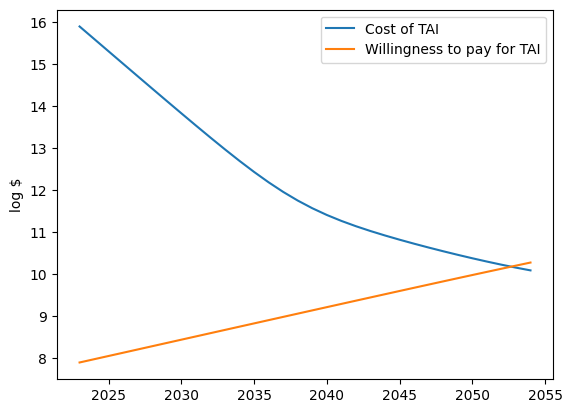

-
-
## SAMPLE RUN 13 ##
It takes 27.8 log FLOP (~6 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~91 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~312 million). This doubles every 3.4 years to a max of 0.112202% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.8 max log FLOP (616 septillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.5 (309 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (987 septillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.6 (379 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.1)
Y

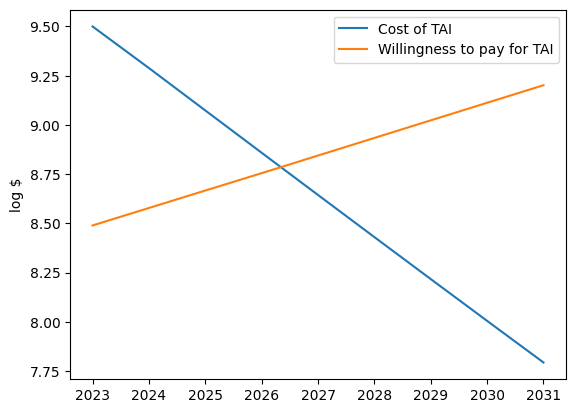

-
-
## SAMPLE RUN 14 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 3.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (803 septillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.4 to buy TAI (2 billion) vs. willingness to pay log $ 8.4 (282 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.0)
Year

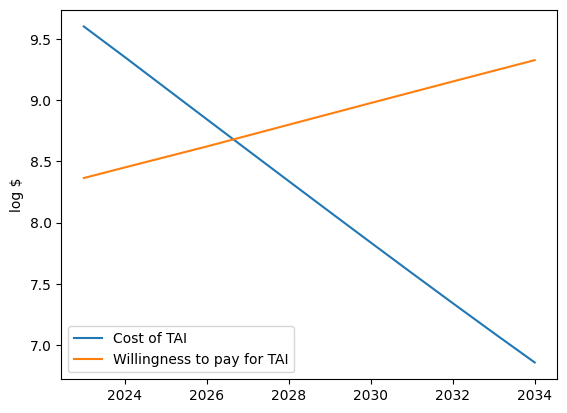

-
-
## SAMPLE RUN 15 ##
It takes 65.1 log FLOP (~126 nonillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 10 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 2.2 years to a max of 0.092646% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.1 max log FLOP (125 septillion) available - TAI takes 65.1 log FLOP (126 nonillion decillion) - log $ 46.8 to buy TAI (63 trillion decillion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.1)
Year: 2024 - 26.4 max log FLOP (232 septillion) available - TAI takes 64.8 log FLOP (63 nonillion decillion) - log $ 46.4 to buy TAI (23 trillion decillion) vs. willingness to pay log $ 7.9 (86 million) - 18.4 log 

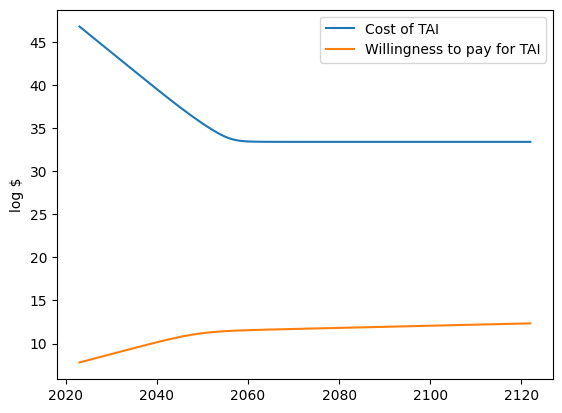

-
-
## SAMPLE RUN 16 ##
It takes 30.6 log FLOP (~4 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 3.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.7 max log FLOP (483 septillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.3 (185 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.8

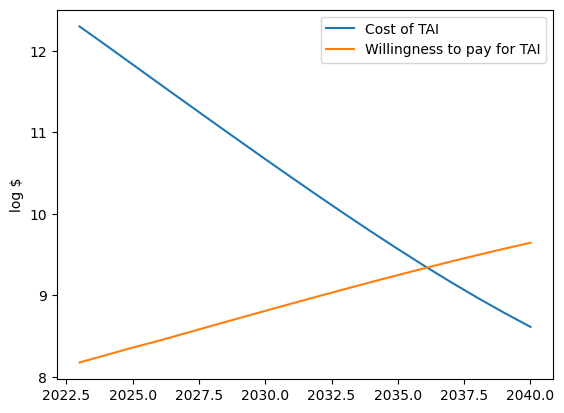

-
-
## SAMPLE RUN 17 ##
It takes 33.2 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~124 million). This doubles every 1.9 years to a max of 0.044786% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.4 max log FLOP (245 septillion) available - TAI takes 33.2 log FLOP (2 decillion) - log $ 14.9 to buy TAI (795 trillion) vs. willingness to pay log $ 8.1 (123 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.7 max log FLOP (458 septillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.6 to buy TAI (439 trillion) vs. willingness to pay log $ 8.2 (177 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLO

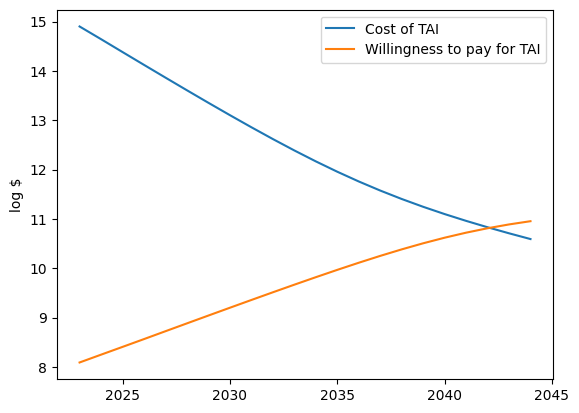

-
-
## SAMPLE RUN 18 ##
It takes 38.3 log FLOP (~200 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~8 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~500 million). This doubles every 2.4 years to a max of 0.701002% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.0 max log FLOP (994 septillion) available - TAI takes 38.3 log FLOP (200 thousand decillion) - log $ 20.0 to buy TAI (100 quintillion) vs. willingness to pay log $ 8.7 (498 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.0)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 38.0 log FLOP (100 thousand decillion) - log $ 19.6 to buy TAI (41 quintillion) vs. willingness to pay log $ 8.8 (661 million) - 18.4 log FLOP per $ (2 qu

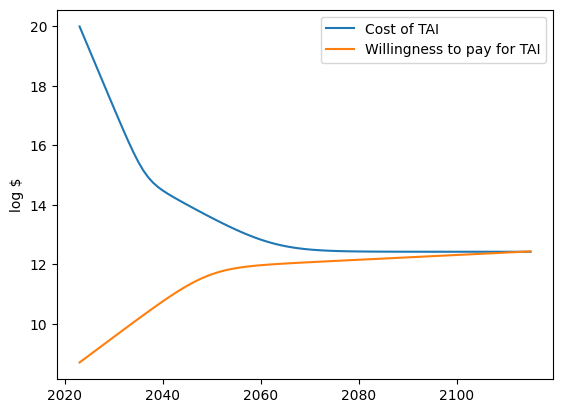

-
-
## SAMPLE RUN 19 ##
It takes 36.8 log FLOP (~6 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 2.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.9 max log FLOP (851 septillion) available - TAI takes 36.8 log FLOP (6 thousand decillion) - log $ 18.5 to buy TAI (3 quintillion) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 36.5 log FLOP (3 thousand decillion) - log $ 18.1 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.7 (548 million) - 18.4 log FLOP per $ (3 quintillion)

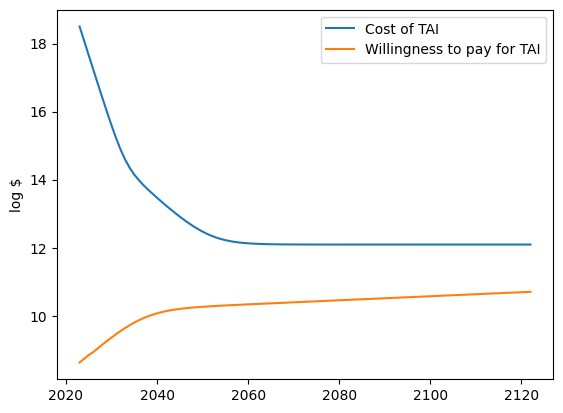

-
-
## SAMPLE RUN 20 ##
It takes 40.9 log FLOP (~79 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~32 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 2.7 years to a max of 0.106344% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.4 max log FLOP (249 septillion) available - TAI takes 40.9 log FLOP (79 million decillion) - log $ 22.6 to buy TAI (40 sextillion) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (392 septillion) available - TAI takes 40.6 log FLOP (40 million decillion) - log $ 22.2 to buy TAI (16 sextillion) vs. willingness to pay log $ 8.2 (161 million) - 18.4 log FLOP per $ (2 quintil

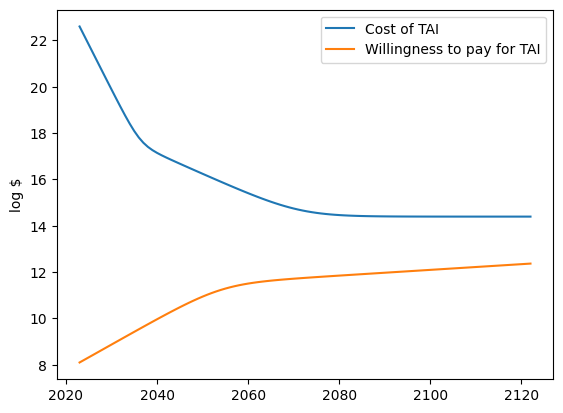

-
-
## SAMPLE RUN 21 ##
It takes 31.6 log FLOP (~40 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.4 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~94 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~195 million). This doubles every 4.3 years to a max of 0.034957% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.6 max log FLOP (379 septillion) available - TAI takes 31.6 log FLOP (40 nonillion) - log $ 13.3 to buy TAI (20 trillion) vs. willingness to pay log $ 8.3 (190 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.7 max log FLOP (545 septillion) available - TAI takes 31.5 log FLOP (31 nonillion) - log $ 13.1 to buy TAI (12 trillion) vs. willingness to pay log $ 8.3 (223 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logF

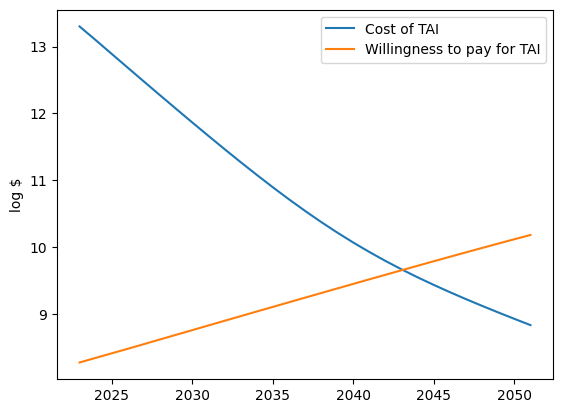

-
-
## SAMPLE RUN 22 ##
It takes 32.0 log FLOP (~100 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~859 million). This doubles every 4.1 years to a max of 0.026524% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 32.0 log FLOP (100 nonillion) - log $ 13.7 to buy TAI (50 trillion) vs. willingness to pay log $ 8.9 (753 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 31.9 log FLOP (72 nonillion) - log $ 13.4 to buy TAI (27 trillion) vs. willingness to pay log $ 8.9 (872 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 

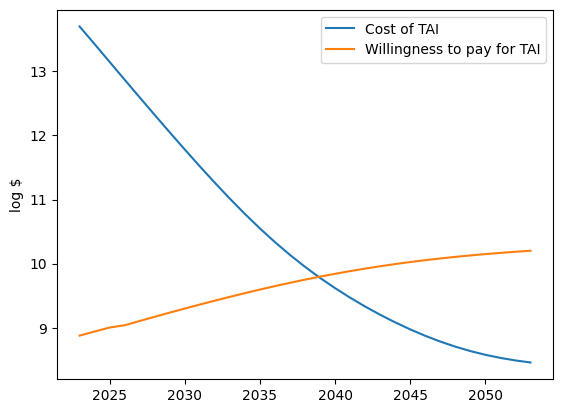

-
-
## SAMPLE RUN 23 ##
It takes 40.1 log FLOP (~13 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~271 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 3.6 years to a max of 0.070115% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 40.1 log FLOP (13 million decillion) - log $ 21.8 to buy TAI (6 sextillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 39.8 log FLOP (6 million decillion) - log $ 21.4 to buy TAI (2 sextillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effecti

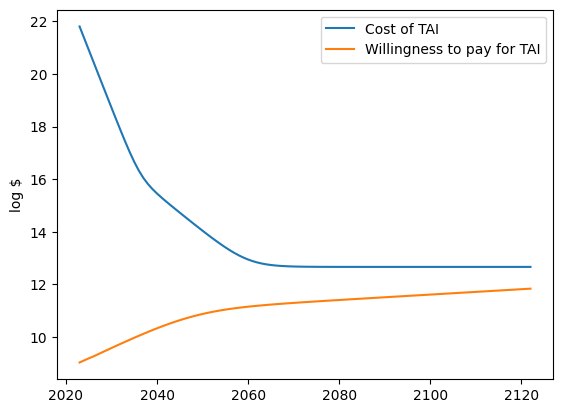

-
-
## SAMPLE RUN 24 ##
It takes 34.2 log FLOP (~16 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 4.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.5 max log FLOP (299 septillion) available - TAI takes 34.2 log FLOP (16 decillion) - log $ 15.9 to buy TAI (8 quadrillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.7 max log FLOP (472 septillion) available - TAI takes 34.0 log FLOP (10 decillion) - log $ 15.6 to buy TAI (4 quadrillion) vs. willingness to pay log $ 8.2 (175 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logF

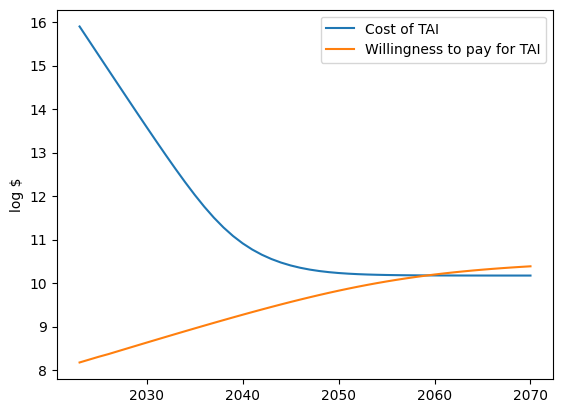

-
-
## SAMPLE RUN 25 ##
It takes 35.1 log FLOP (~126 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 9.6 log 2022$USD (~4 billion). This doubles every 3.9 years to a max of 0.178386% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.9 max log FLOP (8 octillion) available - TAI takes 35.1 log FLOP (126 decillion) - log $ 16.8 to buy TAI (63 quadrillion) vs. willingness to pay log $ 9.6 (4 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.9)
Year: 2024 - 28.2 max log FLOP (14 octillion) available - TAI takes 34.9 log FLOP (79 decillion) - log $ 16.4 to buy TAI (27 quadrillion) vs. willingness to pay log $ 9.7 (5 billion) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP:

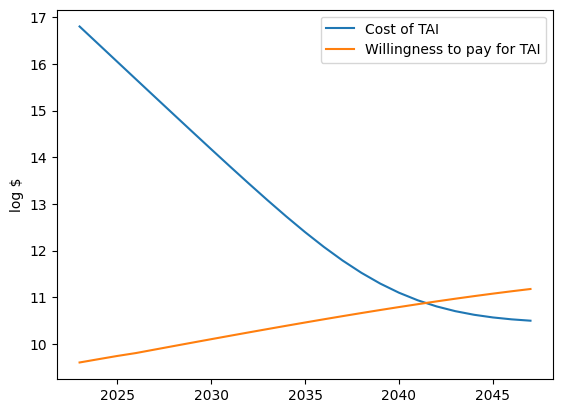

-
-
## SAMPLE RUN 26 ##
It takes 35.2 log FLOP (~158 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~923 million). This doubles every 2.3 years to a max of 0.051779% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.9 to buy TAI (79 quadrillion) vs. willingness to pay log $ 8.9 (856 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 35.0 log FLOP (100 decillion) - log $ 16.6 to buy TAI (37 quadrillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logF

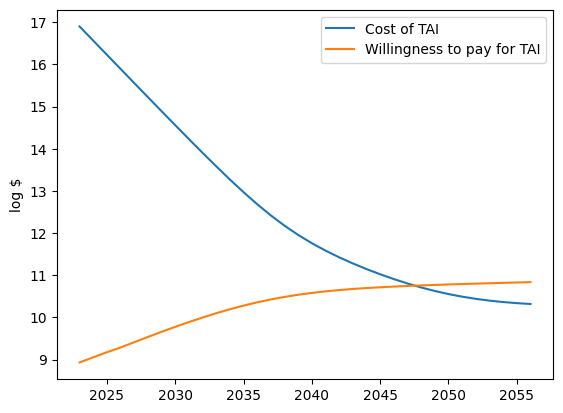

-
-
## SAMPLE RUN 27 ##
It takes 35.3 log FLOP (~200 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~825 quintillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 3.2 years to a max of 0.238226% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.0 max log FLOP (100 septillion) available - TAI takes 35.3 log FLOP (200 decillion) - log $ 17.0 to buy TAI (100 quadrillion) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.0)
Year: 2024 - 26.2 max log FLOP (162 septillion) available - TAI takes 35.1 log FLOP (126 decillion) - log $ 16.7 to buy TAI (48 quadrillion) vs. willingness to pay log $ 7.8 (62 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2

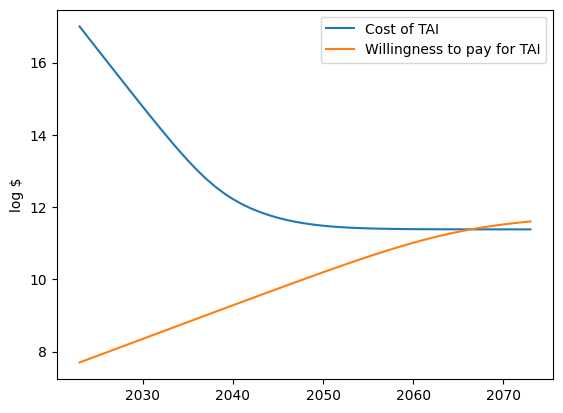

-
-
## SAMPLE RUN 28 ##
It takes 34.6 log FLOP (~40 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~37 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~197 million). This doubles every 2.2 years to a max of 0.058346% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.6 max log FLOP (387 septillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.3 to buy TAI (20 quadrillion) vs. willingness to pay log $ 8.3 (194 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (659 septillion) available - TAI takes 34.4 log FLOP (25 decillion) - log $ 16.0 to buy TAI (10 quadrillion) vs. willingness to pay log $ 8.4 (265 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023

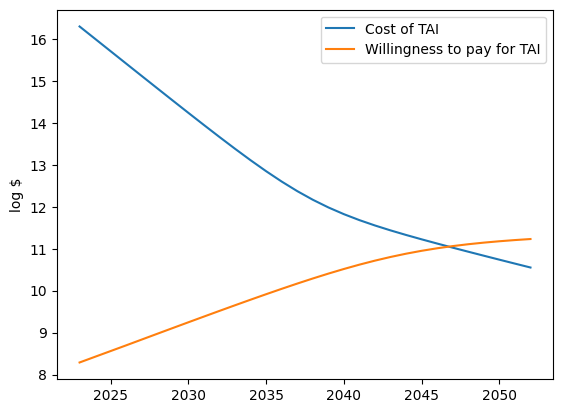

-
-
## SAMPLE RUN 29 ##
It takes 34.8 log FLOP (~63 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~14 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~199 million). This doubles every 1.8 years to a max of 0.224741% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.6 max log FLOP (395 septillion) available - TAI takes 34.8 log FLOP (63 decillion) - log $ 16.5 to buy TAI (32 quadrillion) vs. willingness to pay log $ 8.3 (198 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.9 max log FLOP (828 septillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.1 to buy TAI (14 quadrillion) vs. willingness to pay log $ 8.5 (291 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 202

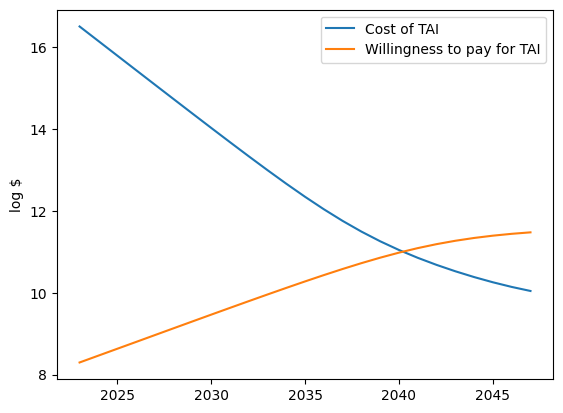

-
-
## SAMPLE RUN 30 ##
It takes 41.1 log FLOP (~126 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~61 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 4.1 years to a max of 0.029986% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.2 max log FLOP (155 septillion) available - TAI takes 41.1 log FLOP (126 million decillion) - log $ 22.8 to buy TAI (63 sextillion) vs. willingness to pay log $ 7.9 (78 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.4 max log FLOP (241 septillion) available - TAI takes 40.8 log FLOP (63 million decillion) - log $ 22.4 to buy TAI (24 sextillion) vs. willingness to pay log $ 8.0 (92 million) - 18.4 log FLOP per $ (3 quinti

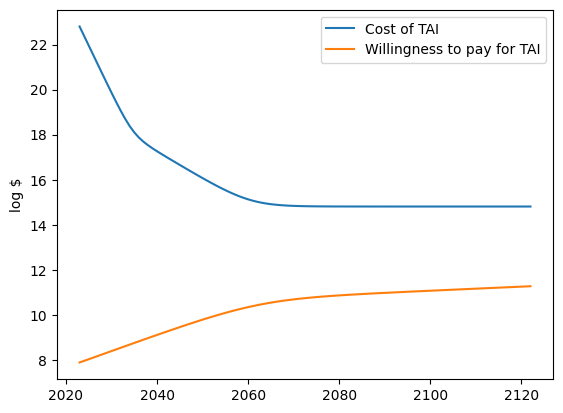

-
-
## SAMPLE RUN 31 ##
It takes 40.2 log FLOP (~16 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 3.9 years to a max of 0.025% of GDP. GDP grows at a rate of 1.038x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 40.2 log FLOP (16 million decillion) - log $ 21.9 to buy TAI (8 sextillion) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (830 septillion) available - TAI takes 39.9 log FLOP (8 million decillion) - log $ 21.4 to buy TAI (3 sextillion) vs. willingness to pay log $ 8.4 (274 million) - 18.5 log FLOP per $ (3 quintillion) 

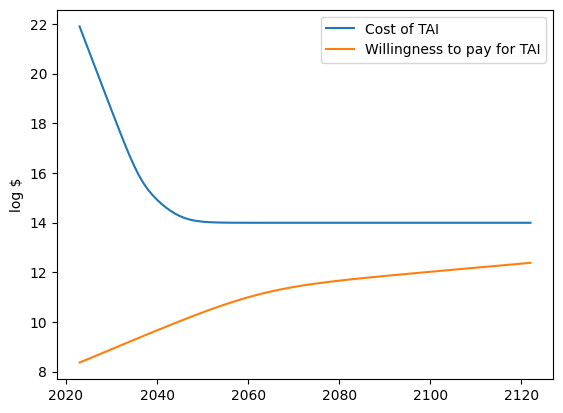

-
-
## SAMPLE RUN 32 ##
It takes 50.8 log FLOP (~631 quadrillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5.4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 1.2 years to a max of 0.094198% of GDP. GDP grows at a rate of 1.037x per year.
---
Year: 2023 - 26.1 max log FLOP (125 septillion) available - TAI takes 50.8 log FLOP (631 quadrillion decillion) - log $ 32.5 to buy TAI (316 nonillion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.1)
Year: 2024 - 26.5 max log FLOP (284 septillion) available - TAI takes 50.5 log FLOP (315 quadrillion decillion) - log $ 32.1 to buy TAI (122 nonillion) vs. willingness to pay log $ 8.0 (110 million) - 18.4 log FLOP p

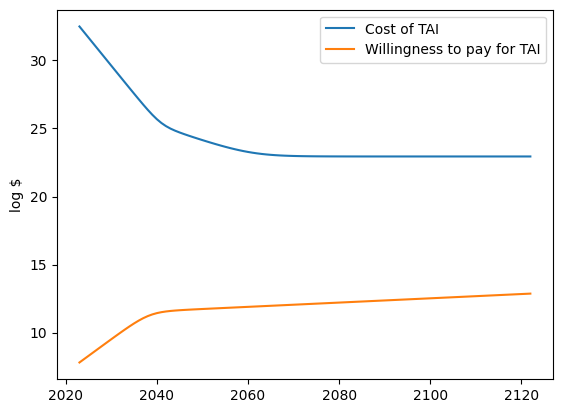

-
-
## SAMPLE RUN 33 ##
It takes 31.0 log FLOP (~10 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 2.6 years to a max of 0.192276% of GDP. GDP grows at a rate of 1.005x per year.
---
Year: 2023 - 26.2 max log FLOP (158 septillion) available - TAI takes 31.0 log FLOP (10 nonillion) - log $ 12.7 to buy TAI (5 trillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.4 max log FLOP (259 septillion) available - TAI takes 30.9 log FLOP (8 nonillion) - log $ 12.5 to buy TAI (3 trillion) vs. willingness to pay log $ 8.0 (104 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 2

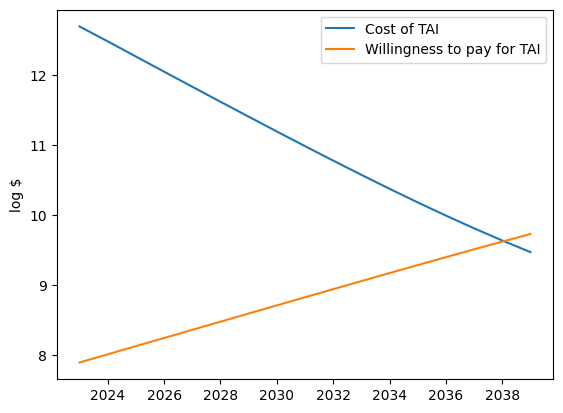

-
-
## SAMPLE RUN 34 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~23 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~392 million). This doubles every 3.7 years to a max of 0.119492% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.9 max log FLOP (772 septillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 8.6 (387 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.8 to buy TAI (60 billion) vs. willingness to pay log $ 8.7 (465 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFL

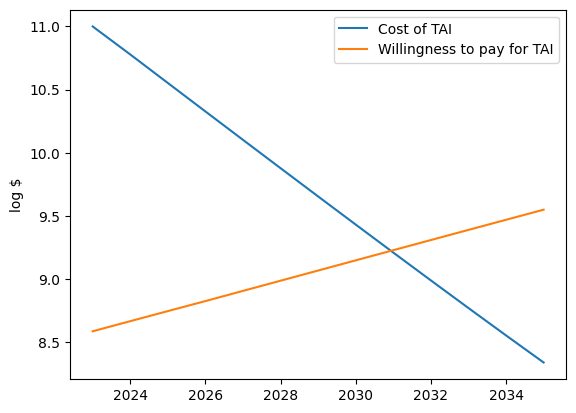

-
-
## SAMPLE RUN 35 ##
It takes 37.8 log FLOP (~63 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~14 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 2.6 years to a max of 0.045221% of GDP. GDP grows at a rate of 1.03x per year.
---
Year: 2023 - 26.2 max log FLOP (156 septillion) available - TAI takes 37.8 log FLOP (63 thousand decillion) - log $ 19.5 to buy TAI (32 quintillion) vs. willingness to pay log $ 7.9 (78 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.4 max log FLOP (270 septillion) available - TAI takes 37.5 log FLOP (32 thousand decillion) - log $ 19.1 to buy TAI (12 quintillion) vs. willingness to pay log $ 8.0 (102 million) - 18.4 log FLOP per $ (3 qui

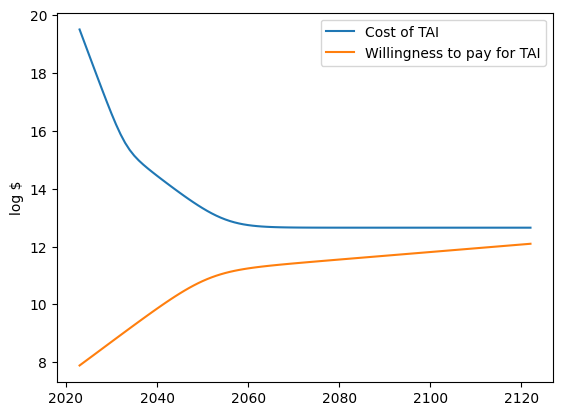

-
-
## SAMPLE RUN 36 ##
It takes 35.4 log FLOP (~251 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 4.0 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 3.6 years to a max of 0.032053% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.2 max log FLOP (155 septillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.1 to buy TAI (126 quadrillion) vs. willingness to pay log $ 7.9 (78 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.3 max log FLOP (224 septillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.8 to buy TAI (67 quadrillion) vs. willingness to pay log $ 8.0 (94 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 20

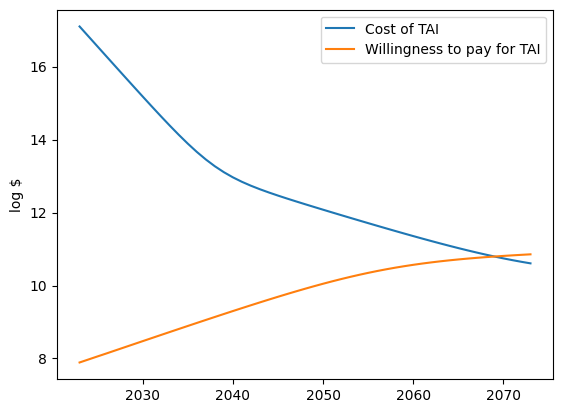

-
-
## SAMPLE RUN 37 ##
It takes 35.6 log FLOP (~398 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~35 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~246 million). This doubles every 3.7 years to a max of 0.053545% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.7 max log FLOP (482 septillion) available - TAI takes 35.6 log FLOP (398 decillion) - log $ 17.3 to buy TAI (200 quadrillion) vs. willingness to pay log $ 8.4 (241 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (801 septillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.0 to buy TAI (91 quadrillion) vs. willingness to pay log $ 8.5 (290 million) - 18.4 log FLOP per $ (3 quintillion) (Effective

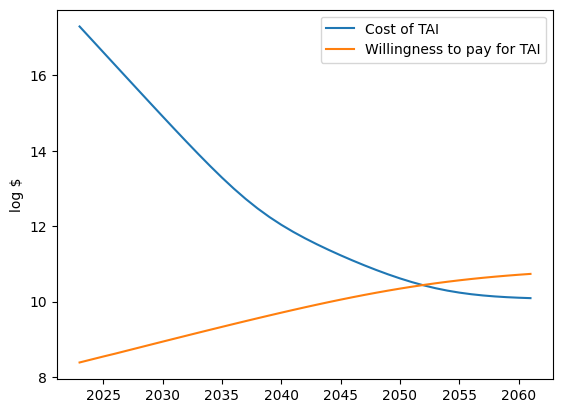

-
-
## SAMPLE RUN 38 ##
It takes 33.4 log FLOP (~3 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~53 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 2.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 33.4 log FLOP (3 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (418 septillion) available - TAI takes 33.3 log FLOP (2 decillion) - log $ 14.9 to buy TAI (714 trillion) vs. willingness to pay log $ 8.2 (166 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP

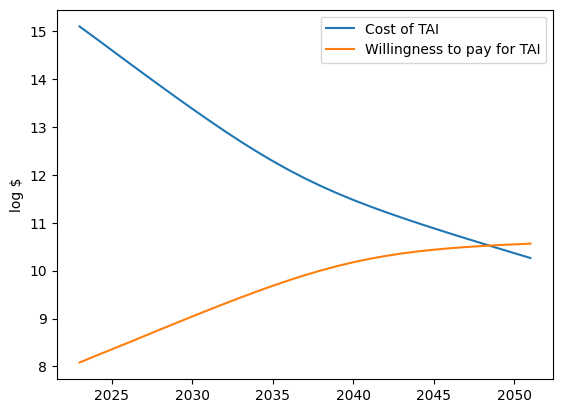

-
-
## SAMPLE RUN 39 ##
It takes 30.4 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.3 log FLOP (~2 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~78 million). This doubles every 3.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.2 max log FLOP (154 septillion) available - TAI takes 30.4 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 7.9 (77 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.4 max log FLOP (241 septillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 11.9 to buy TAI (741 billion) vs. willingness to pay log $ 8.0 (92 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.5)


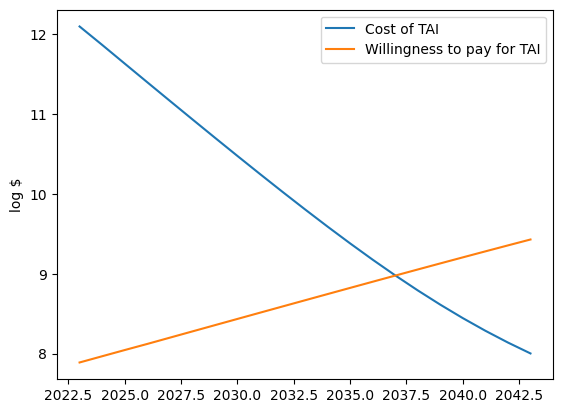

-
-
## SAMPLE RUN 40 ##
It takes 27.2 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 3.8 years to a max of 0.085682% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.4 max log FLOP (248 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.9 to buy TAI (795 million) vs. willingness to pay log $ 8.1 (124 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (375 septillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.7 to buy TAI (506 million) vs. willingness to pay log $ 8.2 (149 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26.

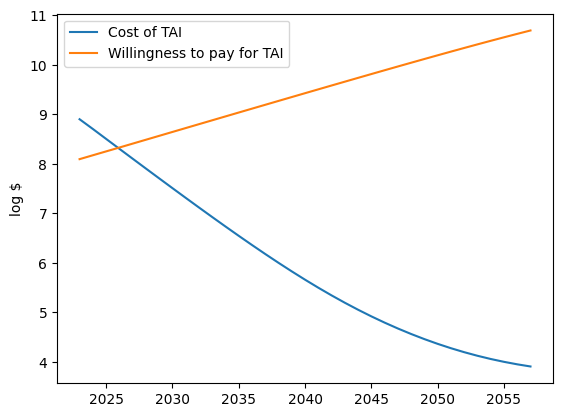

-
-
## SAMPLE RUN 41 ##
It takes 40.5 log FLOP (~32 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~247 million). This doubles every 1.5 years to a max of 0.058854% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.7 max log FLOP (483 septillion) available - TAI takes 40.5 log FLOP (32 million decillion) - log $ 22.2 to buy TAI (16 sextillion) vs. willingness to pay log $ 8.4 (242 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 27.0 max log FLOP (998 septillion) available - TAI takes 40.2 log FLOP (16 million decillion) - log $ 21.8 to buy TAI (6 sextillion) vs. willingness to pay log $ 8.6 (380 million) - 18.4 log FLOP per $ (3 quintilli

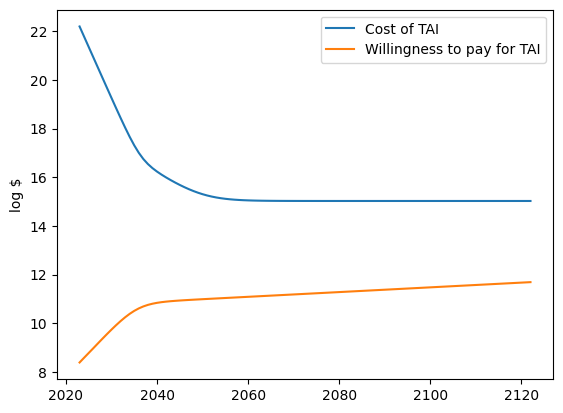

-
-
## SAMPLE RUN 42 ##
It takes 35.1 log FLOP (~126 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~20 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 1.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 35.1 log FLOP (126 decillion) - log $ 16.8 to buy TAI (63 quadrillion) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.7)
Year: 2024 - 26.9 max log FLOP (886 septillion) available - TAI takes 34.9 log FLOP (79 decillion) - log $ 16.5 to buy TAI (31 quadrillion) vs. willingness to pay log $ 8.5 (342 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023

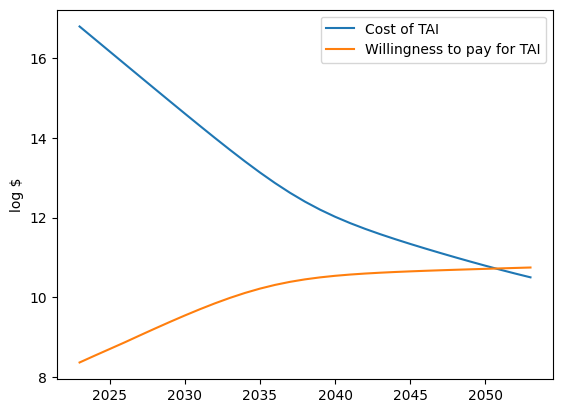

-
-
## SAMPLE RUN 43 ##
It takes 30.2 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~78 million). This doubles every 3.1 years to a max of 0.025361% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.2 max log FLOP (154 septillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.9 to buy TAI (796 billion) vs. willingness to pay log $ 7.9 (77 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.5 max log FLOP (285 septillion) available - TAI takes 30.1 log FLOP (1 nonillion) - log $ 11.6 to buy TAI (411 billion) vs. willingness to pay log $ 8.0 (96 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 26

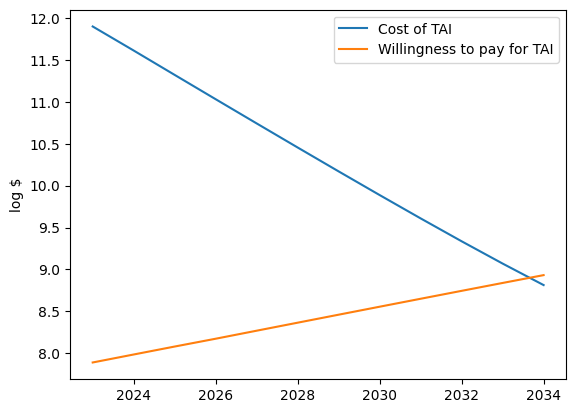

-
-
## SAMPLE RUN 44 ##
It takes 37.1 log FLOP (~13 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.8 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~863 quintillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 1.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.5 max log FLOP (299 septillion) available - TAI takes 37.1 log FLOP (13 thousand decillion) - log $ 18.8 to buy TAI (6 quintillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.5)
Year: 2024 - 26.8 max log FLOP (651 septillion) available - TAI takes 36.8 log FLOP (6 thousand decillion) - log $ 18.3 to buy TAI (2 quintillion) vs. willingness to pay log $ 8.3 (222 million) - 18.5 log FLOP per $ (3 quin

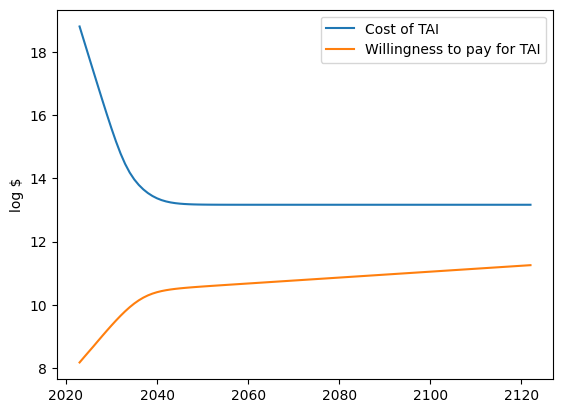

-
-
## SAMPLE RUN 45 ##
It takes 30.3 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.3 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 3.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.3)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.8 to buy TAI (622 billion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.6)
Year: 202

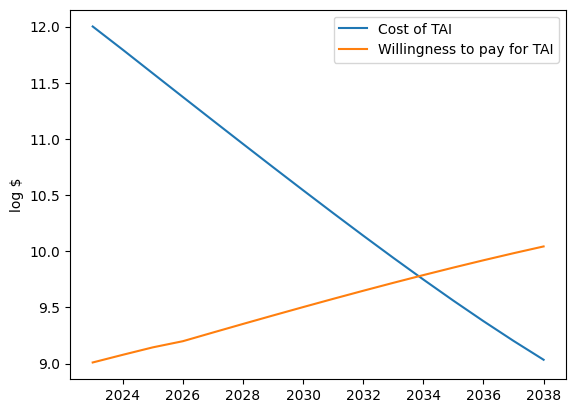

-
-
## SAMPLE RUN 46 ##
It takes 33.2 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 2.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.04x per year.
---
Year: 2023 - 27.2 max log FLOP (2 octillion) available - TAI takes 33.2 log FLOP (2 decillion) - log $ 14.9 to buy TAI (795 trillion) vs. willingness to pay log $ 8.9 (876 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.2)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.6 to buy TAI (433 trillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.6)
Year:

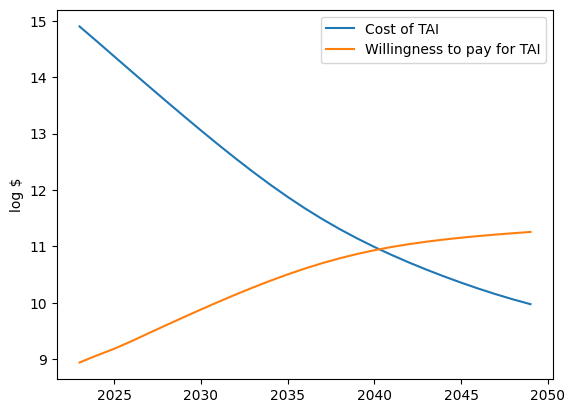

-
-
## SAMPLE RUN 47 ##
It takes 32.5 log FLOP (~316 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~841 quintillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~315 million). This doubles every 2.8 years to a max of 0.554104% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.8 max log FLOP (626 septillion) available - TAI takes 32.5 log FLOP (316 nonillion) - log $ 14.2 to buy TAI (159 trillion) vs. willingness to pay log $ 8.5 (315 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.8)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 32.4 log FLOP (227 nonillion) - log $ 14.0 to buy TAI (91 trillion) vs. willingness to pay log $ 8.6 (402 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-l

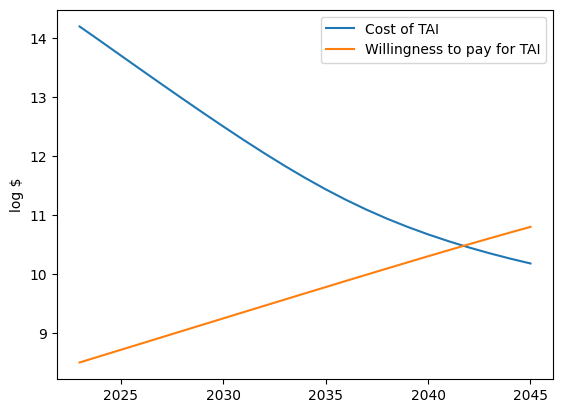

-
-
## SAMPLE RUN 48 ##
It takes 30.2 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~698 million). This doubles every 1.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.9 to buy TAI (795 billion) vs. willingness to pay log $ 8.8 (622 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.1)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 30.1 log FLOP (1 nonillion) - log $ 11.6 to buy TAI (402 billion) vs. willingness to pay log $ 9.0 (893 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.5)
Ye

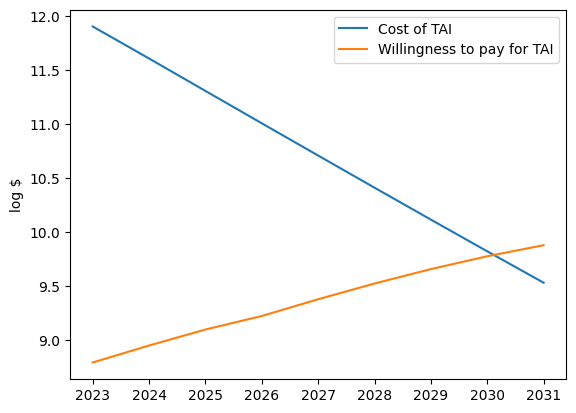

-
-
## SAMPLE RUN 49 ##
It takes 38.1 log FLOP (~126 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 3.8 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~465 million). This doubles every 3.8 years to a max of 0.028137% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.9 max log FLOP (865 septillion) available - TAI takes 38.1 log FLOP (126 thousand decillion) - log $ 19.8 to buy TAI (63 quintillion) vs. willingness to pay log $ 8.6 (434 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 37.8 log FLOP (63 thousand decillion) - log $ 19.3 to buy TAI (22 quintillion) vs. willingness to pay log $ 8.7 (515 million) - 18.5 log FLOP per $ (3 qu

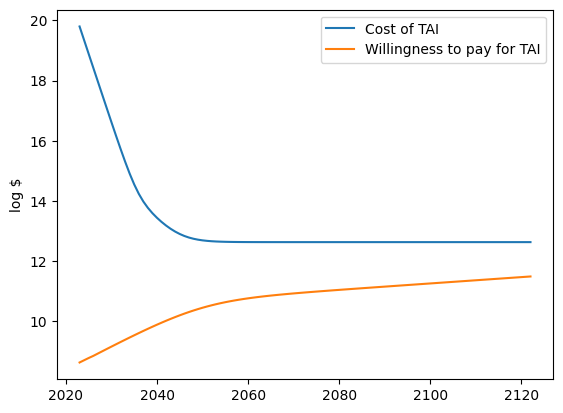

-
-
## SAMPLE RUN 50 ##
It takes 29.1 log FLOP (~126 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~31 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~124 million). This doubles every 1.9 years to a max of 0.038563% of GDP. GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 26.4 max log FLOP (244 septillion) available - TAI takes 29.1 log FLOP (126 octillion) - log $ 10.8 to buy TAI (63 billion) vs. willingness to pay log $ 8.1 (122 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.7 max log FLOP (458 septillion) available - TAI takes 29.0 log FLOP (101 octillion) - log $ 10.6 to buy TAI (39 billion) vs. willingness to pay log $ 8.2 (177 million) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-log

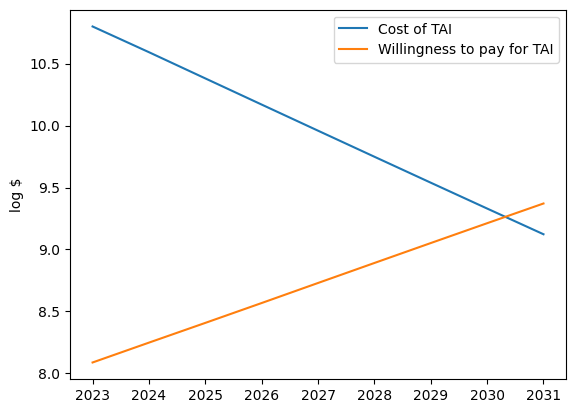

-
-
## SAMPLE RUN 51 ##
It takes 35.2 log FLOP (~158 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.7 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~78 million). This doubles every 2.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.2 max log FLOP (154 septillion) available - TAI takes 35.2 log FLOP (158 decillion) - log $ 16.9 to buy TAI (79 quadrillion) vs. willingness to pay log $ 7.9 (77 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.2)
Year: 2024 - 26.5 max log FLOP (300 septillion) available - TAI takes 35.0 log FLOP (100 decillion) - log $ 16.5 to buy TAI (33 quadrillion) vs. willingness to pay log $ 8.0 (100 million) - 18.5 log FLOP per $ (3 quintillion) (Effective 2023-l

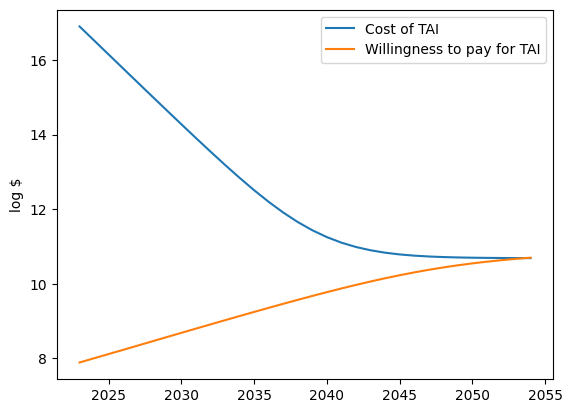

-
-
## SAMPLE RUN 52 ##
It takes 33.1 log FLOP (~1 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~14 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 2.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.01x per year.
---
Year: 2023 - 26.9 max log FLOP (851 septillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.8 to buy TAI (631 trillion) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 33.0 log FLOP (903 nonillion) - log $ 14.6 to buy TAI (362 trillion) vs. willingness to pay log $ 8.7 (543 million) - 18.4 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 2

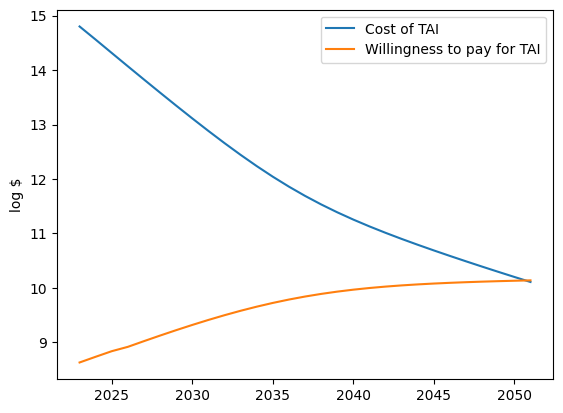

-
-
## SAMPLE RUN 53 ##
It takes 38.1 log FLOP (~126 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 3.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 38.1 log FLOP (126 thousand decillion) - log $ 19.8 to buy TAI (63 quintillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.4)
Year: 2024 - 26.6 max log FLOP (364 septillion) available - TAI takes 37.8 log FLOP (63 thousand decillion) - log $ 19.4 to buy TAI (25 quintillion) vs. willingness to pay log $ 8.2 (146 million) - 18.4 log FLOP per $ (2 quin

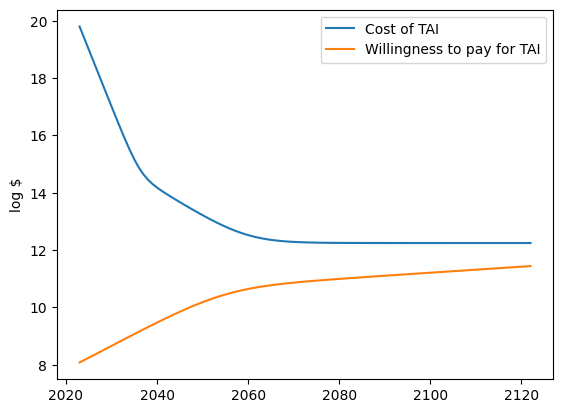

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(verbose=True)